In [1]:
# PINN for Burgers' equation
# coded by St.Watermelon

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Burgers(Model):

    def __init__(self):
        super(Burgers, self).__init__()

        self.h1 = Dense(20, activation='tanh')
        self.h2 = Dense(20, activation='tanh')
        self.h3 = Dense(20, activation='tanh')
        self.h4 = Dense(20, activation='tanh')
        self.h5 = Dense(20, activation='tanh')
        self.h6 = Dense(20, activation='tanh')
        self.u = Dense(1, activation='linear')


    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out

In [3]:
class Pinn(object):

    def __init__(self):

        self.lr = 0.001
        self.opt = Adam(self.lr)

        self.burgers = Burgers()
        self.burgers.build(input_shape=(None, 2))

    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            tape.watch(x)
            xt_t = tf.concat([x,t], axis=1)
            u = self.burgers(xt_t)
            u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u, t)
        del tape

        return u_t + u*u_x - (0.01/np.pi)*u_xx


    def save_weights(self, path):
        self.burgers.save_weights(path + 'a.weights.h5')


    def load_weights(self, path):
        self.burgers.load_weights(path + 'a.weights.h5')


    def learn(self, xt_col, xt_bnd, tu_bnd):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            loss_col = tf.reduce_mean(tf.square(f))

            tu_bnd_hat = self.burgers(xt_bnd)
            loss_bnd = tf.reduce_mean(tf.square(tu_bnd_hat-tu_bnd))

            loss = loss_col + loss_bnd

        grads = tape.gradient(loss, self.burgers.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))

        return loss, loss_col


    def predict(self, xt):
        tu = self.burgers(xt)
        return tu


    def train(self, max_num):

        # initial and boundary condition
        x_data = np.linspace(-1.0, 1.0, 500)
        t_data = np.linspace(0.0, 1.0, 500)
        xt_bnd_data = []
        tu_bnd_data = []

        for x in x_data:
            xt_bnd_data.append([x, 0])
            tu_bnd_data.append([-np.sin(np.pi * x)])

        for t in t_data:
            xt_bnd_data.append([1, t])
            tu_bnd_data.append([0])
            xt_bnd_data.append([-1, t])
            tu_bnd_data.append([0])

        xt_bnd_data = np.array(xt_bnd_data)
        tu_bnd_data = np.array(tu_bnd_data)

        # collocation point
        t_col_data = np.random.uniform(0, 1, [20000, 1])
        x_col_data = np.random.uniform(-1, 1, [20000, 1])
        xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
        xt_col_data = np.concatenate((xt_col_data, xt_bnd_data), axis=0)

        train_loss_history = []
        train_loss_history2 = []

        for iter in range(int(max_num)):

            loss, loss2 = self.learn(tf.convert_to_tensor(xt_col_data, dtype=tf.float32),
                       tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                       tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32))

            train_loss_history.append([iter, loss.numpy()])
            train_loss_history2.append([iter, loss2.numpy()])

            print('iter=', iter, ', loss=', loss.numpy())

        self.save_weights("./save_weights/")

        np.savetxt('./save_weights/loss.txt', train_loss_history)
        np.savetxt('./save_weights/loss2.txt', train_loss_history2)
        train_loss_history = np.array(train_loss_history)
        train_loss_history2 = np.array(train_loss_history2)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.show()

        plt.plot(train_loss_history2[:, 0], train_loss_history2[:, 1])
        plt.yscale("log")
        plt.show()

/Users/jinwoo/workspace/PINN-Tutorial/pinn_tutorial/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'burgers', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


iter= 0 , loss= 0.38863593
iter= 1 , loss= 0.29070067
iter= 2 , loss= 0.2239326
iter= 3 , loss= 0.18286665
iter= 4 , loss= 0.16149691
iter= 5 , loss= 0.15401624
iter= 6 , loss= 0.15515259
iter= 7 , loss= 0.16032021
iter= 8 , loss= 0.16596274
iter= 9 , loss= 0.16990694
iter= 10 , loss= 0.17133826
iter= 11 , loss= 0.17041305
iter= 12 , loss= 0.16778599
iter= 13 , loss= 0.16424465
iter= 14 , loss= 0.160488
iter= 15 , loss= 0.15702203
iter= 16 , loss= 0.15413432
iter= 17 , loss= 0.15191501
iter= 18 , loss= 0.15030299
iter= 19 , loss= 0.14914298
iter= 20 , loss= 0.14824353
iter= 21 , loss= 0.1474271
iter= 22 , loss= 0.1465651
iter= 23 , loss= 0.14559527
iter= 24 , loss= 0.14452152
iter= 25 , loss= 0.14339967
iter= 26 , loss= 0.1423141
iter= 27 , loss= 0.14135061
iter= 28 , loss= 0.14057113
iter= 29 , loss= 0.13999589
iter= 30 , loss= 0.13959636
iter= 31 , loss= 0.13930131
iter= 32 , loss= 0.13901518
iter= 33 , loss= 0.13864262
iter= 34 , loss= 0.13811292
iter= 35 , loss= 0.13739643
iter= 36

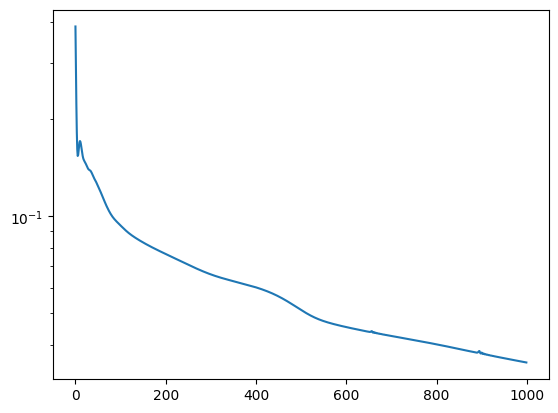

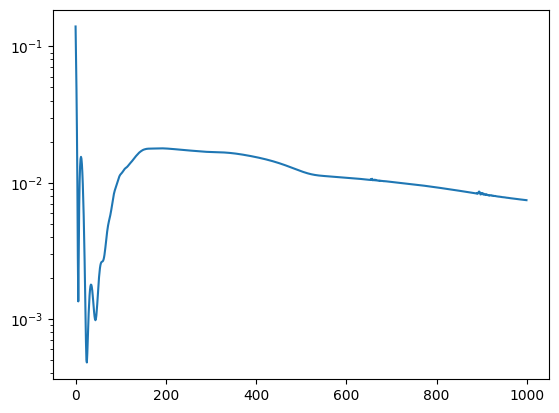

In [4]:
max_num = 1000
agent = Pinn()

agent.train(max_num)